In [19]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd  # Import pandas library for data manipulation and analysis
import numpy as np  # Import numpy library for numerical operations and arrays
import seaborn as sns  # Import seaborn library for data visualization
import matplotlib.pyplot as plt  # Import matplotlib.pyplot module for creating plots and visualizations
from sklearn.model_selection import train_test_split, cross_val_score  # Import functions for data splitting and cross-validation
from sklearn.preprocessing import StandardScaler  # Import StandardScaler class for feature standardization
from sklearn.linear_model import LinearRegression  # Import LinearRegression class for linear regression
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor class for decision tree regression
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor class for random forest regression
from sklearn.metrics import mean_squared_log_error, make_scorer  # Import functions for evaluation metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
import warnings
import requests
warnings.filterwarnings("ignore")

In [20]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submission = pd.read_csv('./data/sample_submission.csv')

In [21]:
df_test

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better
...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions


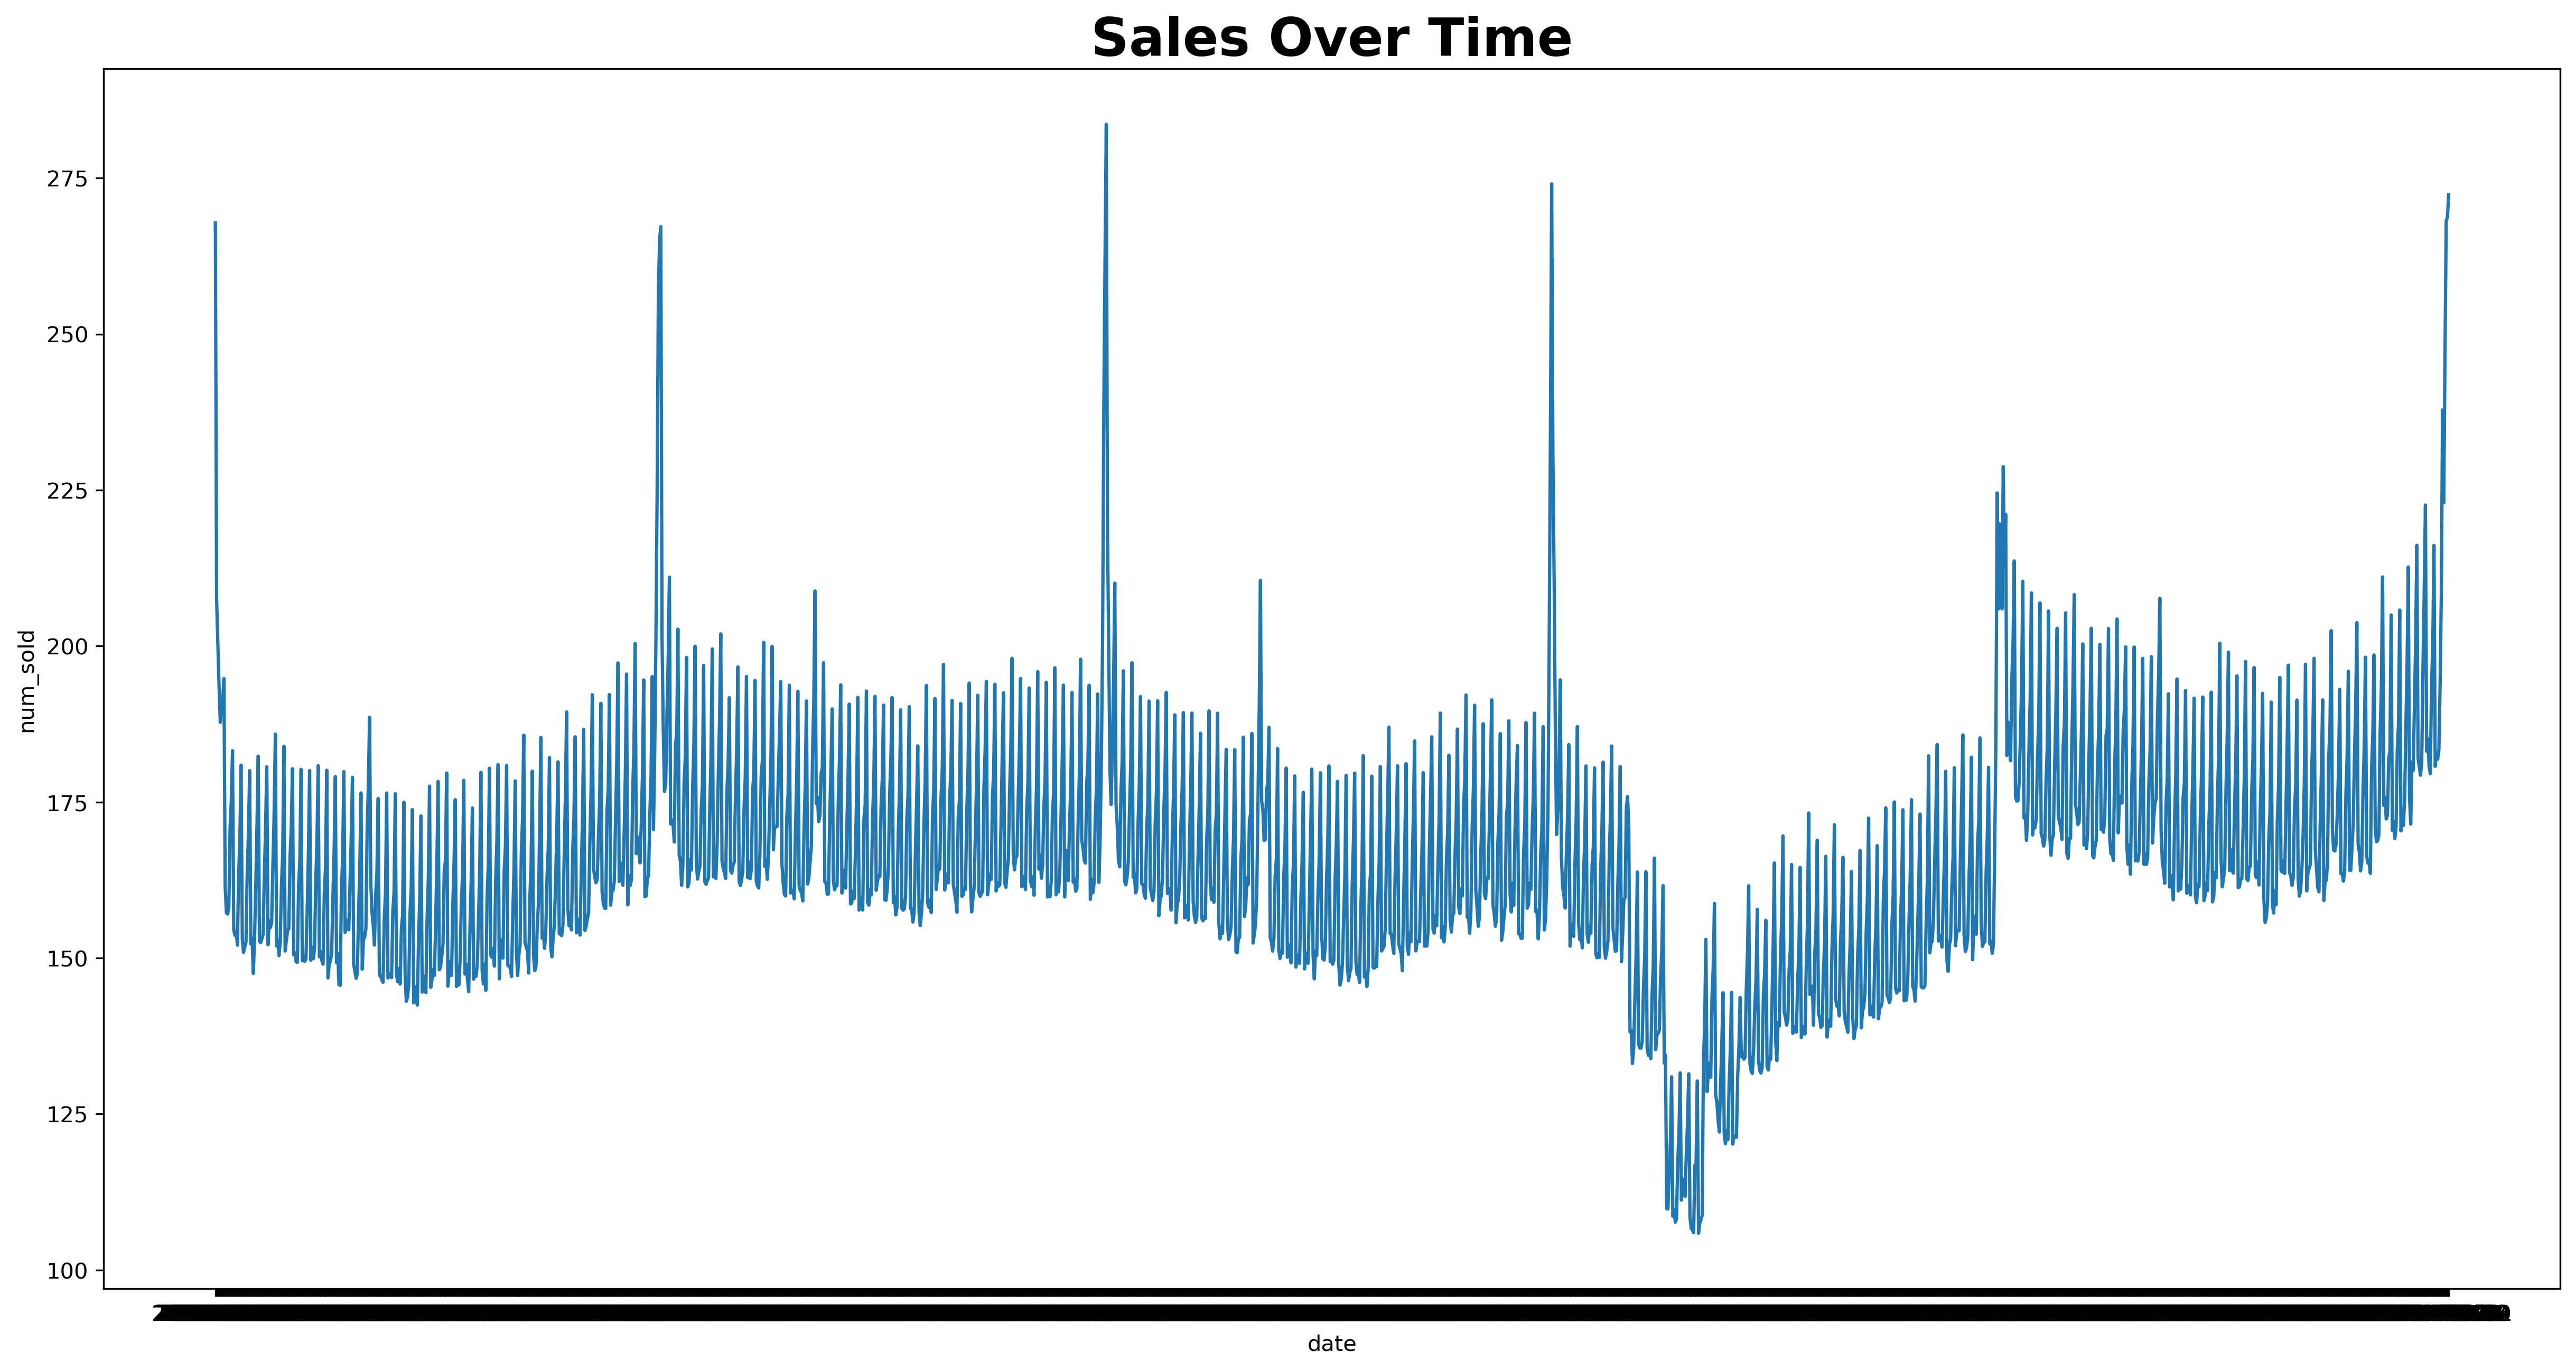

In [22]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = df_train, x = 'date', y = 'num_sold', errorbar = None)
    
plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')
plt.show()

<AxesSubplot:xlabel='date', ylabel='num_sold'>

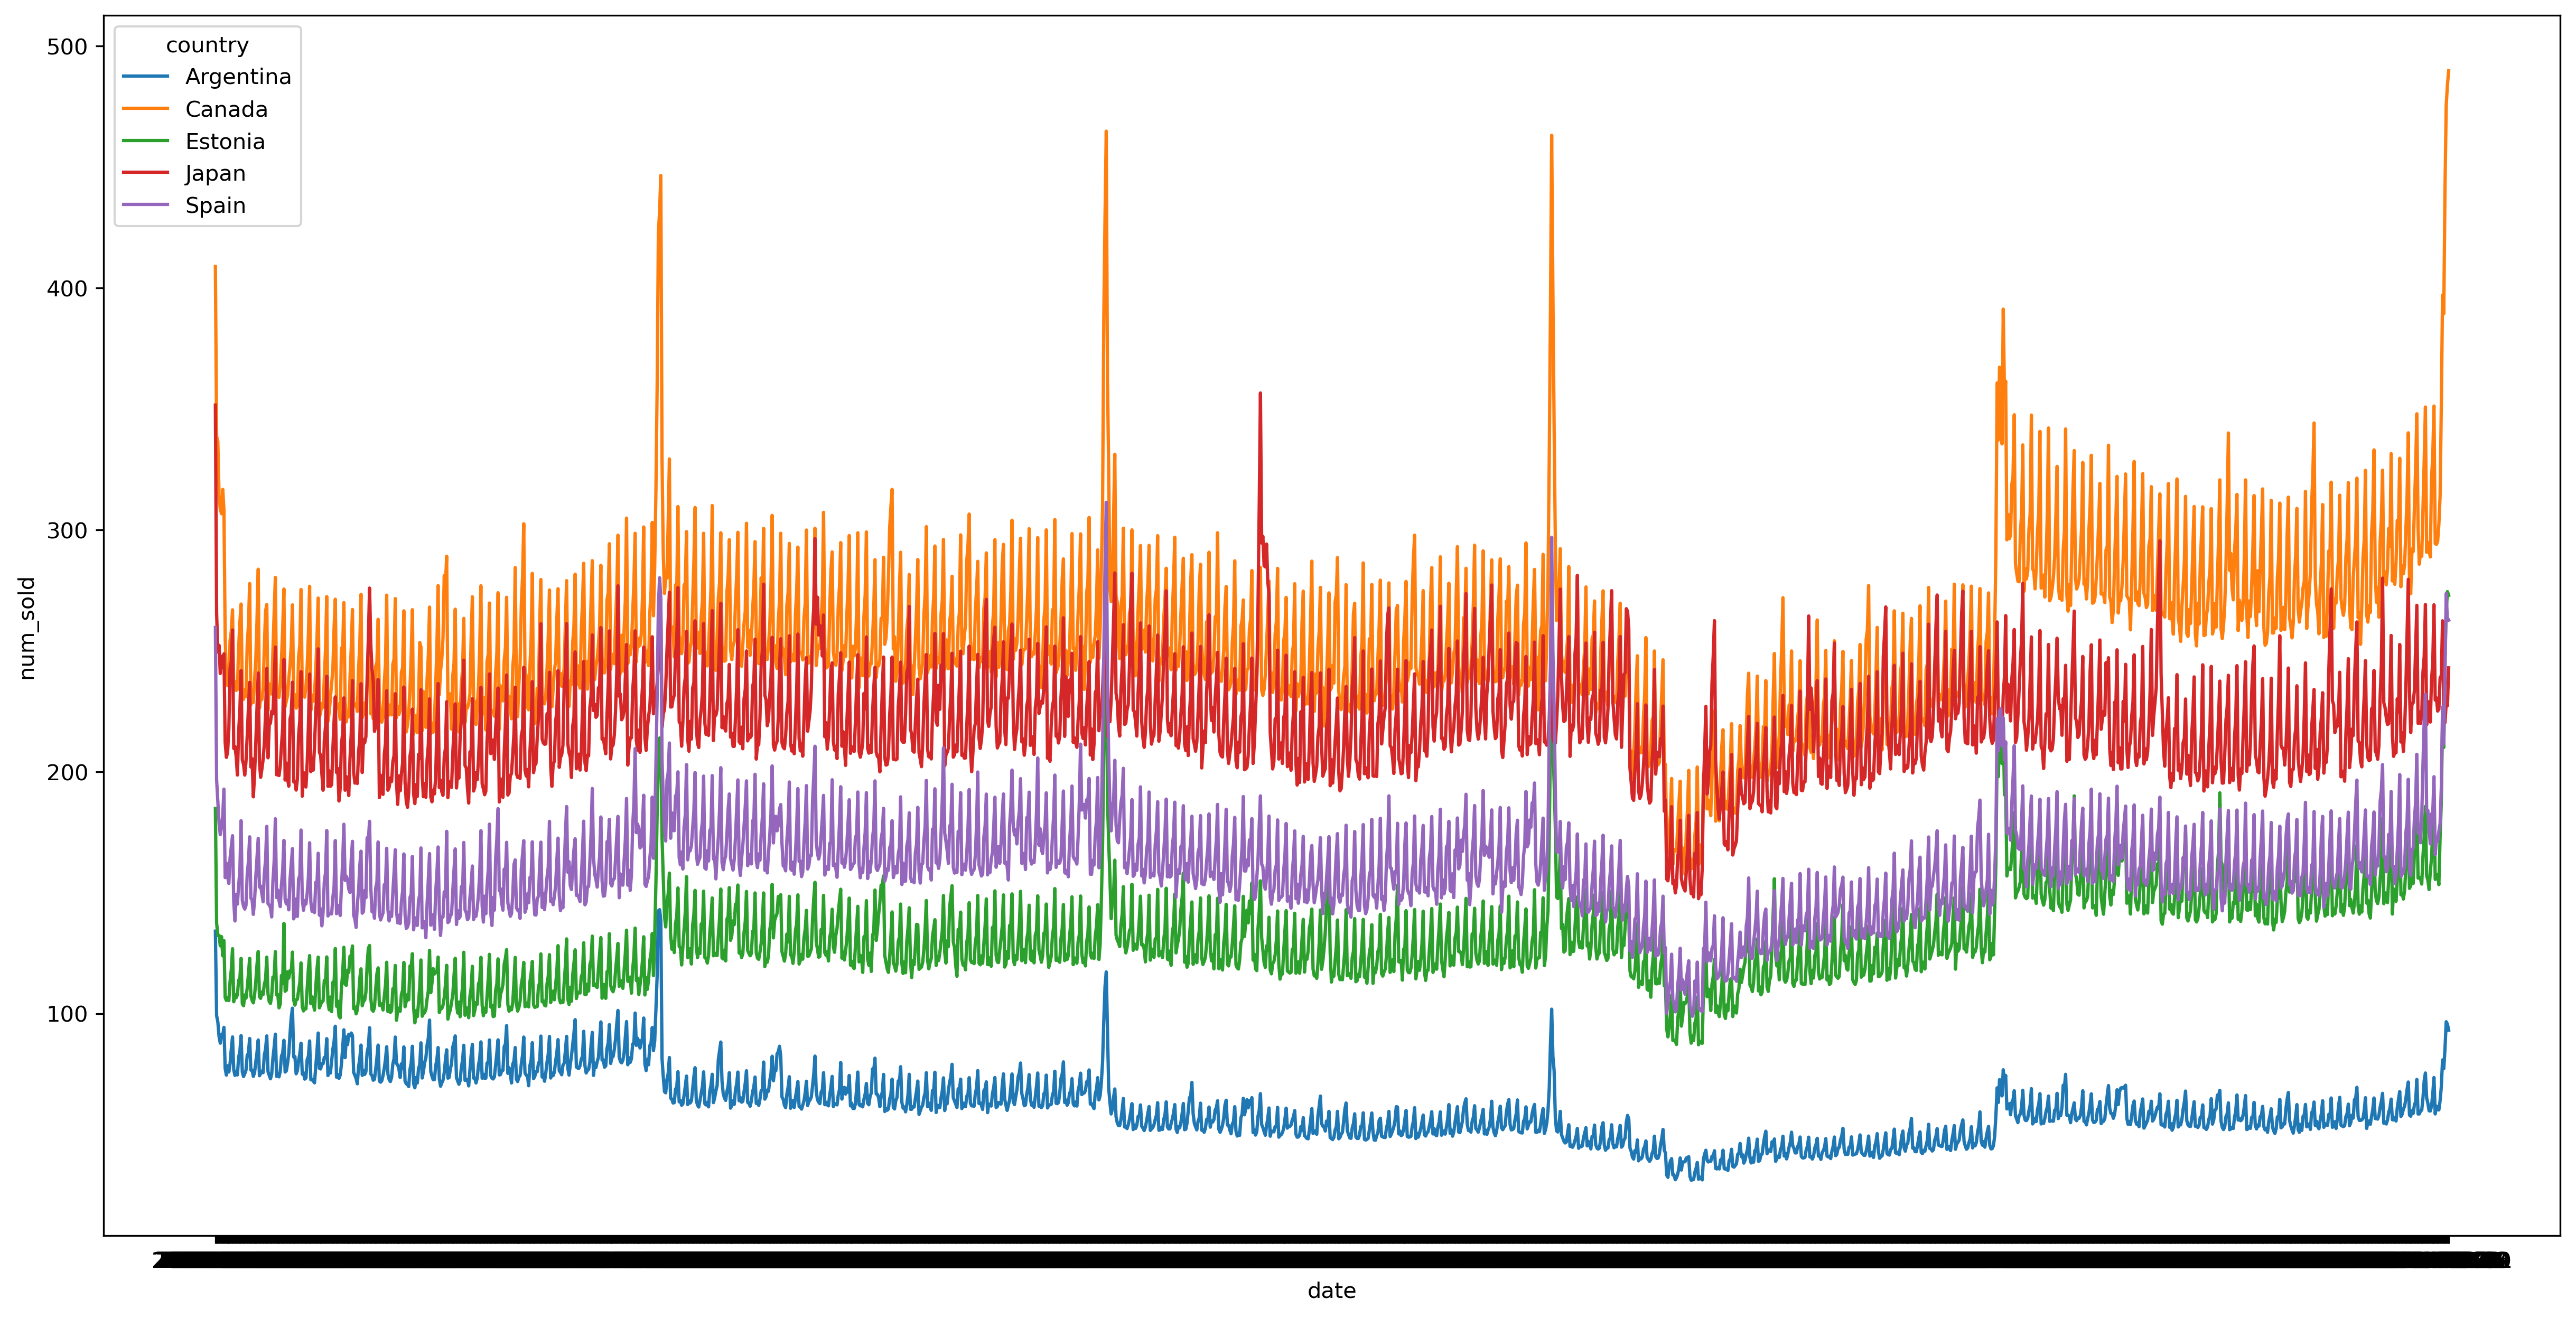

In [23]:
plt.figure(figsize = (20, 10), dpi = 300)
sns.lineplot(data = df_train, x = "date", y = "num_sold", hue = "country", errorbar = None)

In [24]:
# from datetime import datetime
# import calendar
# #对时间进行提取
# def time_process(df):
#     #年、月、日、小时特征提取
#     df['year'] = pd.DatetimeIndex(df['date']).year
#     df['month'] = pd.DatetimeIndex(df['date']).month
#     df['day'] = pd.DatetimeIndex(df['date']).day
#     df['hour'] = pd.DatetimeIndex(df['date']).hour
#     #将日期的礼拜数标出，以探究工作日、双休日的特征
#     df['week'] = pd.DatetimeIndex(df['date']).weekofyear
#     df['weekday'] = pd.DatetimeIndex(df['date']).dayofweek
#     return df

# train = time_process(df_train)
# test = time_process(df_test)

In [25]:
import holidays
def feature_eng(df):
    # Date based features
    
#     df = pd.get_dummies(data = df, columns = ['country','store','product'])
    df['date'] = pd.to_datetime(df['date'])

    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_week'] = df.date.dt.dayofweek
    df['dayname'] = df.date.dt.strftime('%A')
    df['dayofyear'] = df.date.dt.dayofyear
    
    return df


def get_holidays(df):
    # Country holiday based features
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]
    
    holiday_AR = holidays.CountryHoliday('AR', years=years_list)
    holiday_CA = holidays.CountryHoliday('CA', years=years_list)
    holiday_EE = holidays.CountryHoliday('EE', years=years_list)
    holiday_JP = holidays.CountryHoliday('JP', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

def seasonality_features(df):
    
    # getting seasonal patterns
    
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df['day_sin'] = np.sin(2*np.pi*df.day_of_month/31)
    df['day_cos'] = np.cos(2*np.pi*df.day_of_month/31)
    return df

GDP feature:

In [26]:
def get_gdp_per_capita(country,year):
    """
    Retrieve annual GDP per capita for each country from The World Bank API.
    """
    alpha3 = {'Argentina':'ARG','Canada':'CAN','Estonia':'EST','Japan':'JPN','Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

def create_gdp_feature(df):
    """
    Create GDP per capita feature for dataframe.
    """
    df['date'] = pd.to_datetime(df['date'])
    
    for country in df['country'].unique():
        for year in df.date.dt.year.unique():
            gdp = get_gdp_per_capita(country,year)
            df.loc[(df['country']==country)&(df.date.dt.year==year), 'gdp'] = gdp
    gdp_per_capita = df.pop('gdp')
    return gdp_per_capita

In [27]:
train_gdp = create_gdp_feature(df_train)
df_train = pd.concat([df_train, train_gdp], axis=1)

test_gdp = create_gdp_feature(df_test)
df_test = pd.concat([df_test, test_gdp], axis=1)

train = feature_eng(df_train)
test = feature_eng(df_test)

train = seasonality_features(df_train)
test = seasonality_features(df_test)

train = get_holidays(df_train)
test = get_holidays(df_test)


print(f'[INFO] Shapes:'
      f'\n train: {df_train.shape}'
      f'\n test: {df_test.shape}\n')

print(f'[INFO] Any missing values:'
      f'\n train: {df_train.isna().any().any()}'
      f'\n test: {df_test.isna().any().any()}\n')


[INFO] Shapes:
 train: (136950, 19)
 test: (27375, 18)

[INFO] Any missing values:
 train: False
 test: False



In [28]:
# Create an instance of LabelEncoder
le = LabelEncoder()
# Fit and transform the data

train['country'] = le.fit_transform(train['country'])
train['store'] = le.fit_transform(train['store'])
train['product'] = le.fit_transform(train['product'])

test['country'] = le.fit_transform(test['country'])
test['store'] = le.fit_transform(test['store'])
test['product'] = le.fit_transform(test['product'])

train.head()

,id,date,country,store,product,num_sold,gdp,year,month,day_of_month,day_of_week,dayname,dayofyear,month_sin,month_cos,day_sin,day_cos,holiday_name,is_holiday
0,0,2017-01-01,0,1,0,63,14613.035715,2017,1,1,6,Sunday,1,0.5,0.866025,0.201299,0.97953,Año Nuevo; New Year's Day; uusaasta; 元日,1
1,1,2017-01-01,0,1,1,66,14613.035715,2017,1,1,6,Sunday,1,0.5,0.866025,0.201299,0.97953,Año Nuevo; New Year's Day; uusaasta; 元日,1
2,2,2017-01-01,0,1,2,9,14613.035715,2017,1,1,6,Sunday,1,0.5,0.866025,0.201299,0.97953,Año Nuevo; New Year's Day; uusaasta; 元日,1
3,3,2017-01-01,0,1,3,59,14613.035715,2017,1,1,6,Sunday,1,0.5,0.866025,0.201299,0.97953,Año Nuevo; New Year's Day; uusaasta; 元日,1
4,4,2017-01-01,0,1,4,49,14613.035715,2017,1,1,6,Sunday,1,0.5,0.866025,0.201299,0.97953,Año Nuevo; New Year's Day; uusaasta; 元日,1


In [29]:
# 移除疫情期间的数据
for_train=train[train['year'] != 2020]


# 删除无关列
for_train=for_train.drop(['date','id','dayname','holiday_name'], axis=1)

test=test.drop(['date','id','dayname','holiday_name'], axis=1)

# 划分x，y
X_train=for_train.drop('num_sold', axis=1)
y_train=for_train['num_sold'].apply(lambda x: np.log1p(x)).values #取对数：+1防止出现log0的情况


这是没有取对数前的模型训练结果：Here is the model training result without taking the logarithm:

Model: Linear Regression  
Cross-Validation SMAPE: [87.36206891 86.55067731 85.9256166  85.84988203 85.06237241]  
Average SMAPE: 86.15012345313013

Model: Decision Tree  
Cross-Validation SMAPE: [11.91482946  9.69423507  7.78406374  8.94829714  9.7711435 ]  
Average SMAPE: 9.622513781559432

Model: Random Forest  
Cross-Validation SMAPE: [10.86046415  8.13467714  6.10879042  7.62288238  7.98215982]  
Average SMAPE: 8.14179478253398

Model: GradientBoosting Regressor  
Cross-Validation SMAPE: [33.84203174 29.83568807 29.35737129 32.56744355 33.73046199]  
Average SMAPE: 31.866599327643833

Model: AdaBoost Regressor  
Cross-Validation SMAPE: [66.24992749 65.13528294 64.23578959 69.81930548 61.34465928]  
Average SMAPE: 65.35699295682593

Random Forest等tree-based的方法，它们不适合使用包括one-hot以及异常值去除等数据处理方式，甚至也不需要归一化，只需要将数据处理得尽可能接近正态分布即可（取log）。由结果可知取log前与取log后训练的SMAPE有显著减小

Tree-based methods such as Random Forest, which are not suitable for data processing methods such as one-hot and outlier removal, do not even need to be normalized, just need to process data as close to the normal distribution as possible (take log). From the results, it can be seen that the SMAPE trained before and after logging is significantly reduced

In [30]:
# Define SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# Make the RMSLE scorer
rmsle_scorer = make_scorer(smape)

# Initialize and evaluate different regression models using cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'GradientBoosting Regressor':GradientBoostingRegressor(),
    'AdaBoost Regressor':AdaBoostRegressor()
}

for model_name, model in models.items():
    # Perform cross-validation with RMSLE scorer
    cv_scores = cross_val_score(model, X_train, y_train, scoring=rmsle_scorer, cv=5)
    
    print(f"Model: {model_name}")
    print(f"Cross-Validation SMAPE: {cv_scores}")
    print(f"Average SMAPE: {np.mean(cv_scores)}\n")

Model: Linear Regression
Cross-Validation SMAPE: [17.72075055 17.44209903 17.66583381 17.80575477 17.62570497]
Average SMAPE: 17.652028625470287

Model: Decision Tree
Cross-Validation SMAPE: [2.49595445 2.06473518 1.88481758 1.96838604 1.95735418]
Average SMAPE: 2.0742494832759832

Model: Random Forest
Cross-Validation SMAPE: [2.12369659 1.71338109 1.46638465 1.6105598  1.56382273]
Average SMAPE: 1.6955689736747186

Model: GradientBoosting Regressor
Cross-Validation SMAPE: [2.16402256 1.70033087 1.75833083 1.9131595  1.81017026]
Average SMAPE: 1.8692028047163116

Model: AdaBoost Regressor
Cross-Validation SMAPE: [10.35521526 10.06691779 10.2381319   9.24952718 11.18923273]
Average SMAPE: 10.219804971631106



In [31]:
# Fit and evaluate the best model on the test set
best_model = RandomForestRegressor()  # Replace with the best performing model from cross-validation
best_model.fit(X_train, y_train)

RandomForestRegressor()

In [36]:
# Generate predictions for the test data using the previously fit best model 
test_preds = best_model.predict(test)
test_preds=np.exp(test_preds)-1
id=df_test['id']

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test['pred']=test_preds
# Coefficients from https://www.kaggle.com/competitions/playground-series-s3e19/discussion/426427#2355697
# Credit to @paddykb
coef_c = {'Argentina': 3.372, 'Spain': 1.6, 'Japan': 1.394, 'Estonia': 1.651, 'Canada': 0.850}
for c, country in enumerate(df_test['country'].unique()):
    df_test.loc[(df_test['country'] == country), 'pred'] *= coef_c[country]

preds=df_test['pred']

# Create a submission DataFrame with the 'datetime' column and predicted rental counts.
submission = pd.DataFrame({'id': id, 'num_sold': preds})

# Save the submission DataFrame as a CSV file without including the index column.
submission.to_csv('submission.csv', index=False)

Text(0.5, 1.0, 'Sales Over Time')

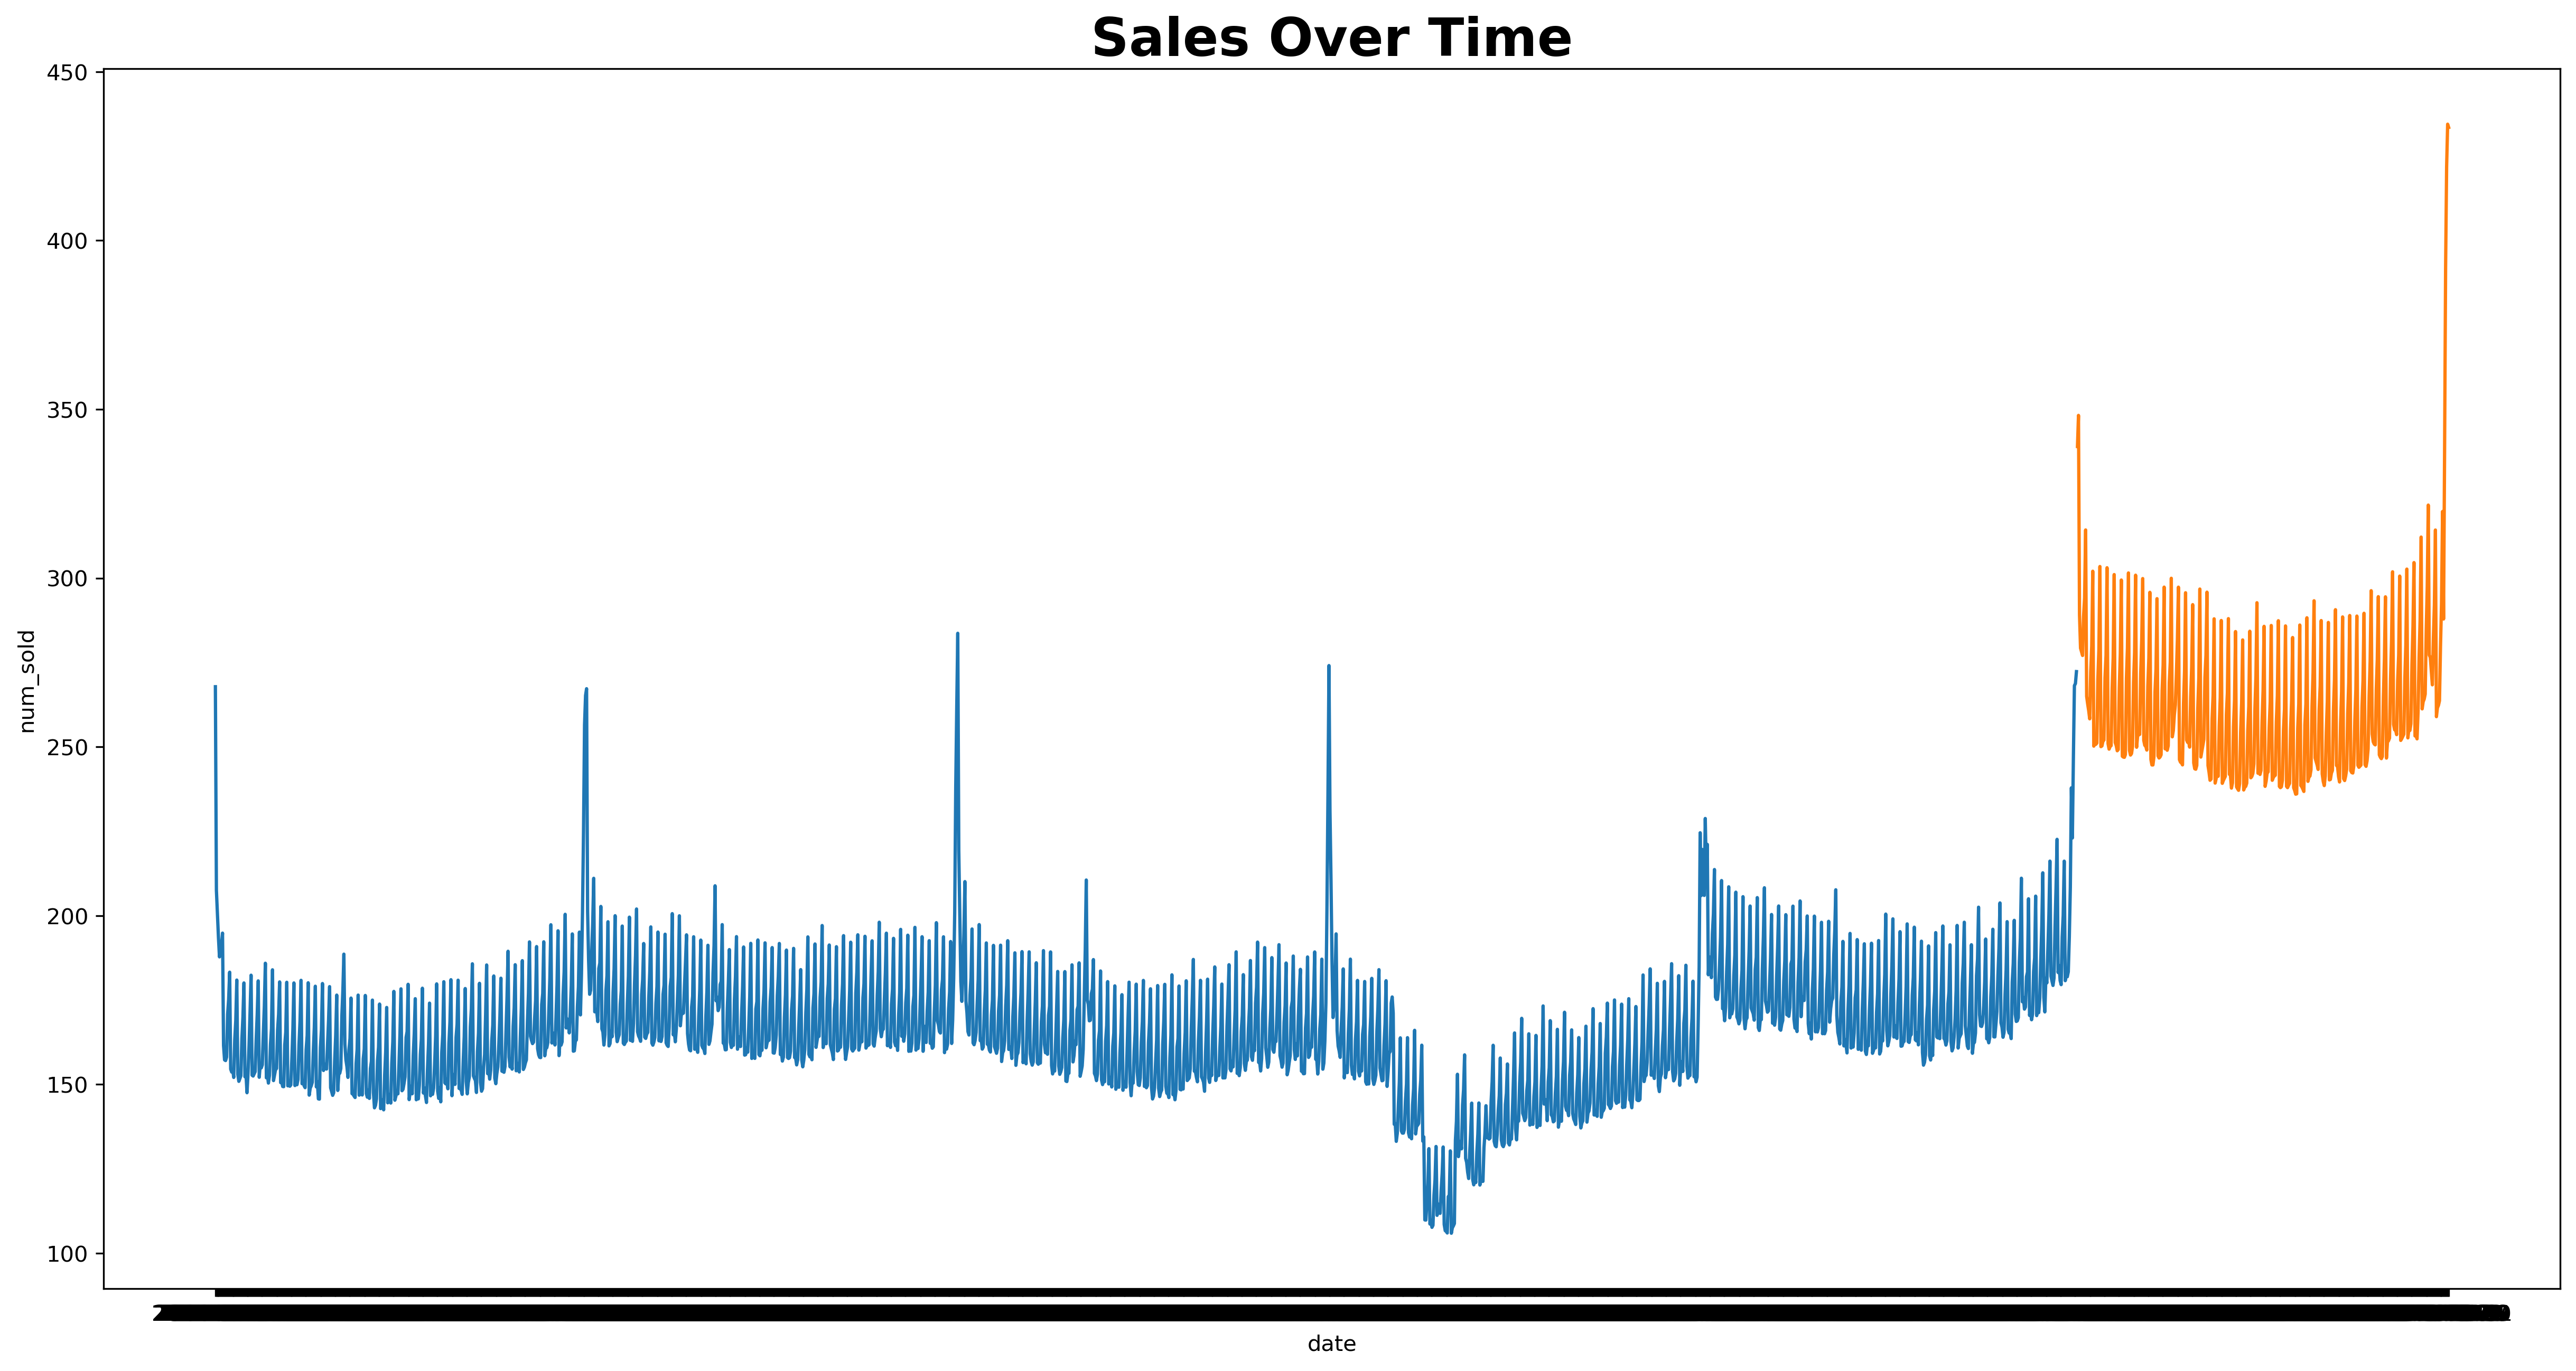

In [37]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = df_train, x = 'date', y = 'num_sold', errorbar = None)
sns.lineplot(data = df_test, x = 'date', y = 'pred', errorbar = None)
    
plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')